# Get multibolid data



In [176]:
from MLABvo.Bolidozor import Bolidozor
import json
import datetime
import numpy as np
import scipy.signal
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib import dates
import sys
sys.path.append("..") 
import recviewer
import dateutil.parser

%matplotlib inline 

# Inicializace bolidozoru

Funkce ```Bolidozor.getMultibolid``` jako jediný parametr bere id skupiny, které lze zjistit například zde: http://rtbolidozor.astro.cz/multibolid/

In [290]:
bz = Bolidozor()
#bolids = bz.getMultibolid(id=1402641)
#bolids = bz.getMultibolid(id=1394295)
#bolids = bz.getMultibolid(id=1371948)
bolids = bz.getMultibolid(id=1374042)
print('Počet detekcí ve skupině je',len(bolids.result))

Počet detekcí ve skupině je 4


Získaná data z MLABvo jsou k dispozici v ```Bolidozor.getMultibolid.result```.

Následující buňka ukazuje, jak lze procházet záznamy po jednom.

**Výsledek obsahuje následující informace**

In [275]:
print(list(bolids.result[0].keys()))

['url_file', 'url_file_raw', 'noise', 'duration', 'filename', 'id_observer', 'peak_f', 'obstime', 'observatory_namesimple', 'observatory_name', 'namesimple', 'file_status', 'filename_raw', 'url_station', 'filepath', 'url_file_js9', 'station_name', 'magnitude', 'event_id', 'id_server']


# Kalibrace času

tato funkce projde RAW soubory a snaží se v nich vyhledat GPS značku. 

Výstupem této funkce je ```dictionary```, který obsahuje informace o času na začátku souboru, času konce souboru a prvního vzorku s GPS značkou ze systémového času stanice. Tyto samé časy vrací taktéž oproti GPS času.


In [284]:
def timeCalibration(raw_file, sigma = 18, debug = True):
    calibration_data = {}
    hdulist = fits.open(raw_file)
    met_data = np.abs(np.ravel(hdulist[0].data))
    clip_val = np.std(met_data)*sigma
    plt.axhline(y=clip_val, color='red')
    max_val = np.max(met_data)
    for i, point in enumerate(met_data):
        if point > clip_val:
            plt.axvline(x=i, color='red')
            ten_sec = 10/(hdulist[0].header['CDELT2']/2/1000.0)
            if debug: plt.axvline(x=i+ten_sec, color='green')
            break
    file_length = hdulist[0].header['NAXIS2']*hdulist[0].header['CDELT2']/1000.0
    time_firstGPS = i/2*hdulist[0].header['CDELT2']/1000.0
    DATE_OBS = datetime.datetime.strptime(hdulist[0].header['DATE-OBS'], "%Y-%m-%dT%H:%M:%S" )
    
    gps = (DATE_OBS-datetime.timedelta(seconds=file_length-time_firstGPS)).timestamp()
    round_gps = round(gps/10.0)*10
    correction = datetime.timedelta(seconds=round_gps-gps)

    calibration_data['sys_correction'] = correction
    
    calibration_data['sys_file_beg'] = DATE_OBS-datetime.timedelta(seconds=file_length)
    calibration_data['sys_file_end'] = DATE_OBS
    calibration_data['sys_1st_GPS'] = DATE_OBS-datetime.timedelta(seconds=file_length-time_firstGPS)
    calibration_data['sys_error'] = DATE_OBS-datetime.timedelta(seconds=file_length-time_firstGPS)
    
    calibration_data['cor_file_beg'] = DATE_OBS-datetime.timedelta(seconds=file_length)+correction
    calibration_data['cor_file_end'] = DATE_OBS+correction
    calibration_data['cor_1st_GPS'] = DATE_OBS-datetime.timedelta(seconds=file_length-time_firstGPS)+correction
    calibration_data['cor_error'] = correction
    
    if debug:
        file_length = hdulist[0].header['NAXIS2']*hdulist[0].header['CDELT2']/1000.0
        time_firstGPS = i/2*hdulist[0].header['CDELT2']/1000.0
        DATE_OBS = datetime.datetime.strptime(hdulist[0].header['DATE-OBS'], "%Y-%m-%dT%H:%M:%S" )
        print("Zpracovavam soubor:", raw_file)
        print('delka zaznamu          :', file_length, "s")
        print('cas prvni vzorku s GPS :', time_firstGPS, "s")
        print('cas 1. GPS a konec     :', file_length - time_firstGPS, "s")
        print('SysCas ukladani souboru:', calibration_data['sys_file_end'], "s")
        print('SysCas zacatku souboru :', calibration_data['sys_file_beg'])
        print('SysCas 1. GPS znacky   :', calibration_data['sys_1st_GPS'])
        print('Korekce systémoveho čas:', correction)
        print('CorCas ukladani souboru:', calibration_data['cor_file_end'], "s")
        print('CorCas zacatku souboru :', calibration_data['cor_file_beg'])
        print('CorCas 1. GPS znacky   :', calibration_data['cor_1st_GPS'])
        plt.plot(met_data)
        plt.show()
    return calibration_data
        

Tato smyčka projde všechny soubory a použije na nich funkci pro kalibraci času. Výstup přidá do původní proměnné pod klíčem ```time_calib```.

0 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/CIIRC/CIIRC-R1/meteors/2017/09/15/10/20170915101215954_CIIRC-R1_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/CIIRC/CIIRC-R1/meteors/2017/09/15/10/20170915101215954_CIIRC-R1_raws.fits
delka zaznamu          : 5.800001856 s
cas prvni vzorku s GPS : 5.799996647665 s
cas 1. GPS a konec     : 5.208334999728947e-06 s
SysCas ukladani souboru: 2017-09-15 10:12:15 s
SysCas zacatku souboru : 2017-09-15 10:12:09.199998
SysCas 1. GPS znacky   : 2017-09-15 10:12:14.999995
Korekce systémoveho čas: -1 day, 23:59:55.000005
CorCas ukladani souboru: 2017-09-15 10:12:10.000005 s
CorCas zacatku souboru : 2017-09-15 10:12:04.200003
CorCas 1. GPS znacky   : 2017-09-15 10:12:10


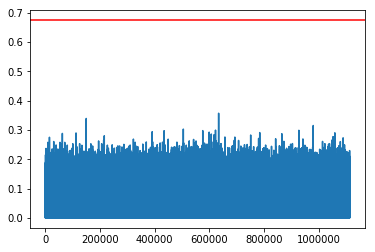

1 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/15/10/20170915101059387_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/15/10/20170915101059387_SVAKOV-R12_raws.fits
delka zaznamu          : 22.600007232 s
cas prvni vzorku s GPS : 6.39348121258 s
cas 1. GPS a konec     : 16.20652601942 s
SysCas ukladani souboru: 2017-09-15 10:10:59 s
SysCas zacatku souboru : 2017-09-15 10:10:36.399993
SysCas 1. GPS znacky   : 2017-09-15 10:10:42.793474
Korekce systémoveho čas: -1 day, 23:59:57.206526
CorCas ukladani souboru: 2017-09-15 10:10:56.206526 s
CorCas zacatku souboru : 2017-09-15 10:10:33.606519
CorCas 1. GPS znacky   : 2017-09-15 10:10:40


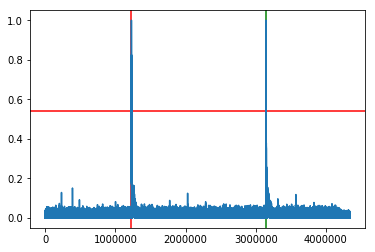

2 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2017/09/15/10/20170915101751863_DDMTREBIC-R3_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2017/09/15/10/20170915101751863_DDMTREBIC-R3_raws.fits
delka zaznamu          : 20.800006655999997 s
cas prvni vzorku s GPS : 5.62300179936 s
cas 1. GPS a konec     : 15.177004856639996 s
SysCas ukladani souboru: 2017-09-15 10:17:51 s
SysCas zacatku souboru : 2017-09-15 10:17:30.199993
SysCas 1. GPS znacky   : 2017-09-15 10:17:35.822995
Korekce systémoveho čas: 0:00:04.177005
CorCas ukladani souboru: 2017-09-15 10:17:55.177005 s
CorCas zacatku souboru : 2017-09-15 10:17:34.376998
CorCas 1. GPS znacky   : 2017-09-15 10:17:40


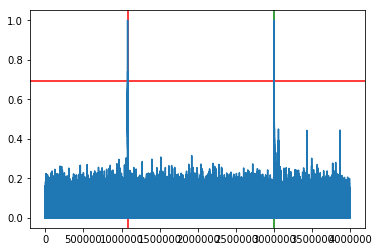

3 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/HFN/HFN-R1/meteors/2017/09/15/10/20170915101701203_HFN-R1_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/HFN/HFN-R1/meteors/2017/09/15/10/20170915101701203_HFN-R1_raws.fits
delka zaznamu          : 20.600006591999996 s
cas prvni vzorku s GPS : 5.5557830278499996 s
cas 1. GPS a konec     : 15.044223564149997 s
SysCas ukladani souboru: 2017-09-15 10:17:01 s
SysCas zacatku souboru : 2017-09-15 10:16:40.399993
SysCas 1. GPS znacky   : 2017-09-15 10:16:45.955776
Korekce systémoveho čas: 0:00:04.044224
CorCas ukladani souboru: 2017-09-15 10:17:05.044224 s
CorCas zacatku souboru : 2017-09-15 10:16:44.444217
CorCas 1. GPS znacky   : 2017-09-15 10:16:50


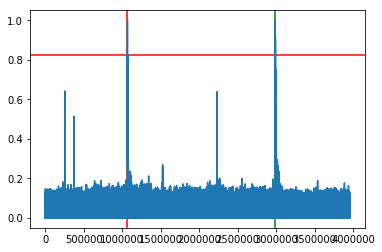

In [291]:

for i, bolid in enumerate(bolids.result):
    print(i,"==================================")
    print("snapshot:", bolid['url_file_js9'])
    bolids.result[i]['time_calib']=timeCalibration(bolid['url_file_raw'])
    

# Filtr nevyhovujících dat

Protože v některých datech nemusí být dobře detekovatelná GPS značka, je zde možné tyto soubory ručně vyřadit. A to tím, že odkomentujete druhý řádek následující buňky a do seznamu napíšete čísla vyhovujících RAW souborů. (Jsou k nalezení ve výstupu předchozí buňky)

In [292]:
selected = range(0, len(bolids.result))
selected = [1,2,3]     #Pokud chcete vybrat konkrétní data, 
                               #odkomentujte tento řádek a vložte do něj čísla požadovaných dat

for i, bolid in enumerate(bolids.result):
    if i in selected:
        print(i, ',sysT of gps:', bolid['time_calib']['cor_1st_GPS'], ',offset:', bolid['time_calib']['cor_error'], bolid['filename'])

1 ,sysT of gps: 2017-09-15 10:10:40 ,offset: -1 day, 23:59:57.206526 20170915101059387_SVAKOV-R12_met.fits
2 ,sysT of gps: 2017-09-15 10:17:40 ,offset: 0:00:04.177005 20170915101751863_DDMTREBIC-R3_met.fits
3 ,sysT of gps: 2017-09-15 10:16:50 ,offset: 0:00:04.044224 20170915101701203_HFN-R1_met.fits


# Zarovnané soubory

Toto je první buňka, jejíž výstup obsahuje časově zarovnané grafy. Pomocí proměnné ```gps_calib``` můžete nastavit, zdali Vaše zarovnání bude oproti absolutním GPS značkám (```gps_calib=True```) nebo oproti systémovému času stanic (```gps_calib=False```).

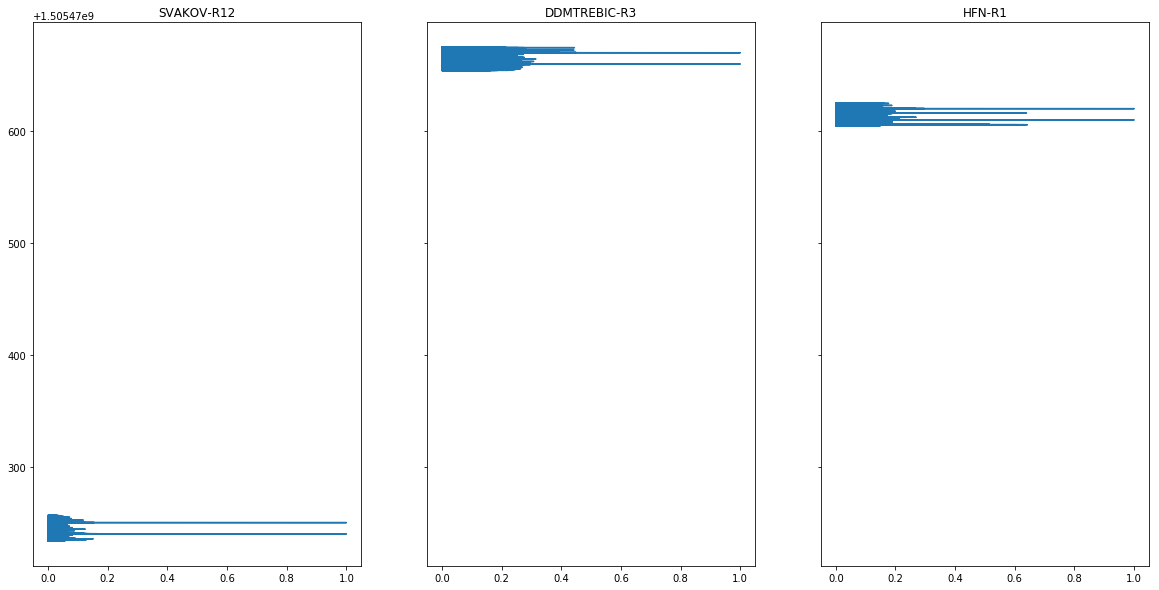

In [294]:
%matplotlib inline 
count = len(selected)
fig, axis = plt.subplots(1, count, sharex=True, sharey=True, figsize=(20, 10))

gps_calib = True

for i, ax in enumerate(axis):
    bolid = bolids.result[selected[i]]
    #print (i, bolid['time_calib']['cor_file_beg'])
    hdulist = fits.open(bolid['url_file_raw'])
    met_data = np.abs(np.ravel(hdulist[0].data))
    
    if gps_calib:
        min_date = bolid['time_calib']['cor_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()
        max_date = bolid['time_calib']['cor_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()
    else:
        min_date = bolid['time_calib']['sys_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()
        max_date = bolid['time_calib']['sys_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()
    array = np.arange(min_date, max_date, (max_date-min_date)/len(met_data))
    
    ax.set_title(bolid['namesimple'])
    ax.plot(met_data, array)

fig.subplots_adjust(hspace=0)

In [295]:
def waterfall(signal, sample_rate=None, bins = 4096 ):
    waterfall = recviewer.waterfallize(signal, bins)
    waterfall[np.isneginf(waterfall)] = np.nan
    wmin, wmax = np.nanmin(waterfall), np.nanmax(waterfall)
    return waterfall

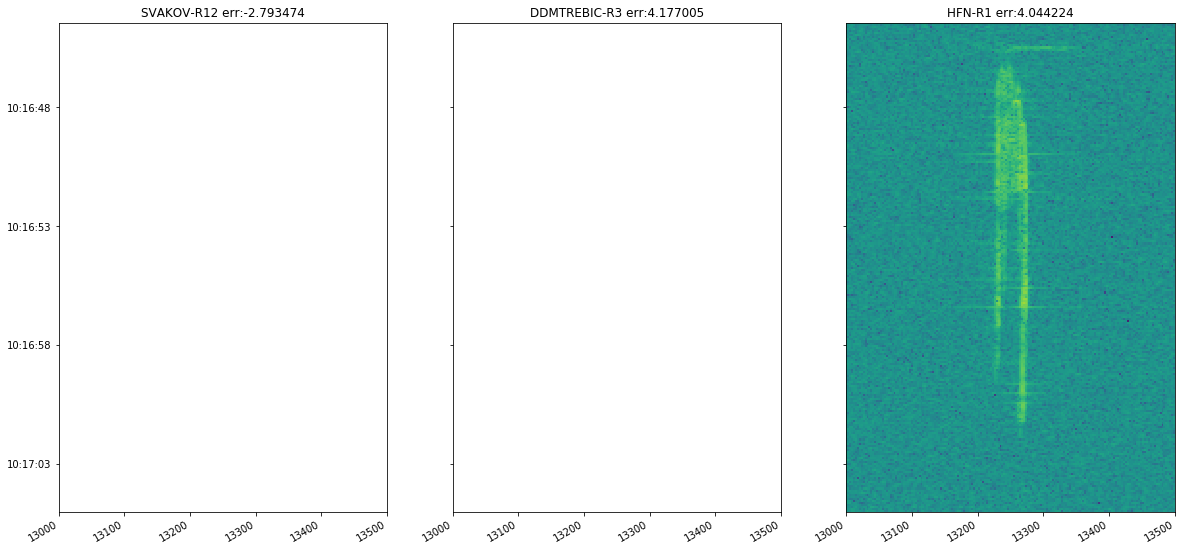

In [302]:
%matplotlib inline 
#%matplotlib notebook
count = len(selected)
fig, axis = plt.subplots(1, count, sharex=True, sharey=True, figsize=(20, 10))

for i, ax in enumerate(axis):
    bolid = bolids.result[selected[i]]
    hdu = fits.open(bolid['url_file_raw'])[0]
    flat_data = np.ravel(hdu.data)
    
    d1 = bolid['time_calib']['cor_file_beg']
    fds1 = dates.date2num(d1) # converted
    d2 = d1 + datetime.timedelta(seconds=hdu.header['NAXIS2']/48000.0/2)
    fds2 = dates.date2num(d2)
    
    arr = waterfall(flat_data[0::2] + 1j * flat_data[1::2], 48000, bins = 4096*4)
    ax.imshow(arr,  interpolation='none', aspect='auto',  extent=[-24000, 24000, fds2, fds1])
    
    ax.set_xlim(13000,13500)
    ax.yaxis_date()
    date_format = md.DateFormatter('%H:%M:%S')
    ax.yaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    
    offset = abs(bolid['time_calib']['cor_error']).microseconds/1000000 + abs(bolid['time_calib']['cor_error']).seconds
    if bolid['time_calib']['cor_error'] < datetime.timedelta(seconds=0): offset = -offset
    ax.set_title(bolid['namesimple']+ " err:"+str(offset))